# How do delivery fees vary across platforms and locations?

In [2]:

import sqlite3
import pandas as pd
import folium
from folium.plugins import HeatMap
import webbrowser
from pathlib import Path

TAKEAWAY_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db"
UBEREATS_DB  = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\ubereats.db"
DELIVEROO_DB = r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\deliveroo.db"

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Connect + attach
conn = sqlite3.connect(DELIVEROO_DB)
conn.execute(f"ATTACH DATABASE '{TAKEAWAY_DB}' AS ta;")
conn.execute(f"ATTACH DATABASE '{UBEREATS_DB}' AS ue;")

takeaway_sql = """
SELECT
    l.postalCode,
    ROUND(AVG(CAST(r.deliveryFee AS REAL)), 2) AS delivery_fee
FROM ta.restaurants r
JOIN ta.locations_to_restaurants lr
  ON r.primarySlug = lr.restaurant_id
JOIN ta.locations l
  ON lr.location_id = l.ID
WHERE l.postalCode IS NOT NULL
  AND r.deliveryFee IS NOT NULL
  AND TRIM(r.deliveryFee) <> ''
GROUP BY l.postalCode
ORDER BY delivery_fee DESC;
"""

df_takeaway_fees = q(conn, takeaway_sql)
df_takeaway_fees.head(20)


,postalCode,delivery_fee
0,3791,7.13
1,3793,6.00
2,3061,5.86
3,9688,5.60
4,3792,5.58
5,3717,5.40
6,3790,5.18
7,1761,5.18
8,1750,5.11
9,1755,4.90


# Deliveroo delivery cost

In [3]:
deliveroo_sql = """
SELECT
    postal_code,
    ROUND(AVG(CAST(delivery_fee AS REAL)), 2) AS delivery_fee
FROM restaurants
WHERE delivery_fee IS NOT NULL
  AND TRIM(delivery_fee) <> ''
  AND postal_code IS NOT NULL
GROUP BY postal_code
ORDER BY delivery_fee ASC;
"""

df_deliveroo_fees = q(conn, deliveroo_sql)
df_deliveroo_fees.head(20)


,postal_code,delivery_fee
0,2050,1.00
1,1020,4.41
2,8501,4.59
3,1800,4.68
4,9300,4.80
5,1150,4.85
6,8310,4.89
7,2140,4.92
8,3800,4.92
9,1090,4.93


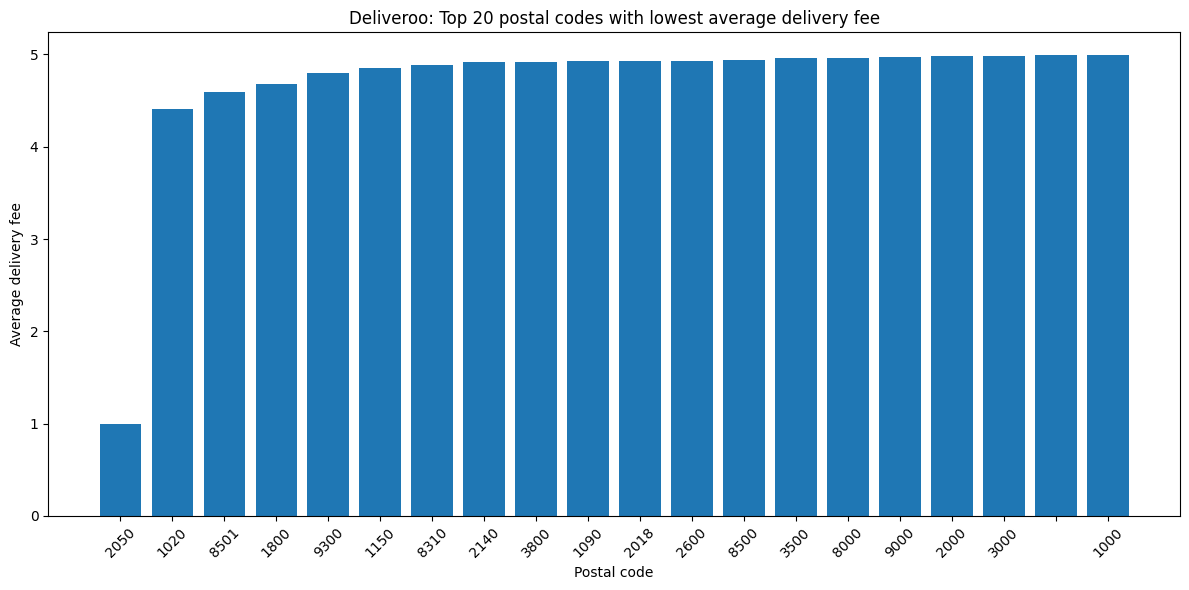

In [16]:
import matplotlib.pyplot as plt

top20 = df_deliveroo_fees.head(20)

plt.figure(figsize=(12, 6))
plt.bar(top20["postal_code"].astype(str), top20["delivery_fee"])
plt.title("Deliveroo: Top 20 postal codes with lowest average delivery fee")
plt.xlabel("Postal code")
plt.ylabel("Average delivery fee")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Average ratings by category and platform

In [25]:
import pandas as pd

def q(con, sql, params=None):
    return pd.read_sql_query(sql, con, params=params)

# Deliveroo (main)
query_deliveroo = """
SELECT 
    category AS Category,
    ROUND(AVG(rating), 2) AS "Average rating",
    'Deliveroo' AS Platform
FROM restaurants
WHERE category IN ('Italian', 'Burgers', 'Sushi', 'Turkish', 'Thai')
GROUP BY category;
"""

# Takeaway (ta)
query_takeaway = """
WITH mapped AS (
  SELECT
    CASE
      WHEN cr.category_id IN ('italian-pizza_271', 'pasta_1614') THEN 'Italian'
      WHEN cr.category_id = 'burgers_1984' THEN 'Burgers'
      WHEN cr.category_id IN ('thai_61', 'curry_731') THEN 'Thai'
      WHEN cr.category_id IN ('pita-kebab_651', 'shoarma_2014', 'turkish-pizza', 'turkish_511') THEN 'Turkish'
      WHEN cr.category_id IN ('sushi_51', 'japanene_551') THEN 'Sushi'
      ELSE NULL
    END AS Category,
    r.ratings AS rating
  FROM ta.categories_restaurants cr
  JOIN ta.restaurants r
    ON cr.restaurant_id = r.primarySlug
)
SELECT
  Category,
  ROUND(AVG(rating), 2) AS "Average rating",
  'Takeaway' AS Platform
FROM mapped
WHERE Category IN ('Italian', 'Burgers', 'Sushi', 'Turkish', 'Thai')
  AND rating IS NOT NULL
GROUP BY Category;
"""

# UberEats (ue)
query_ubereats = """
WITH mapped AS (
  SELECT
    CASE
      WHEN rtc.category IN ('Kebab', 'Turks', 'Turque') THEN 'Turkish'
      WHEN rtc.category IN ('Japans', 'Japonaise') THEN 'Sushi'
      WHEN rtc.category IN ('Pizza', 'Pizzas', 'Italiaans', 'Italienne', 'Pasta') THEN 'Italian'
      WHEN rtc.category IN ('Hamburgers', 'Amerikaans', 'AmÃ©ricain') THEN 'Burgers'
      WHEN rtc.category IN ('Thais') THEN 'Thai'
      ELSE NULL
    END AS Category,
    r.rating__rating_value AS rating
  FROM ue.restaurant_to_categories rtc
  JOIN ue.restaurants r
    ON r.id = rtc.restaurant_id
)
SELECT
  Category,
  ROUND(AVG(rating), 2) AS "Average rating",
  'Ubereats' AS Platform
FROM mapped
WHERE Category IN ('Italian', 'Burgers', 'Sushi', 'Turkish', 'Thai')
  AND rating IS NOT NULL
GROUP BY Category;
"""

df_deliveroo = q(conn, query_deliveroo)
df_takeaway  = q(conn, query_takeaway)
df_ubereats  = q(conn, query_ubereats)

df = pd.concat([df_deliveroo, df_takeaway, df_ubereats], ignore_index=True)
df["Average rating"] = pd.to_numeric(df["Average rating"], errors="coerce").round(2)

df_result = df.groupby(["Category", "Platform"], as_index=False)["Average rating"].mean()
df_result["Average rating"] = df_result["Average rating"].round(2)

df_result


,Category,Platform,Average rating
0,Burgers,Deliveroo,2.75
1,Burgers,Takeaway,3.64
2,Burgers,Ubereats,4.19
3,Italian,Deliveroo,2.90
4,Italian,Takeaway,3.78
5,Italian,Ubereats,4.26
6,Sushi,Deliveroo,2.70
7,Sushi,Takeaway,4.01
8,Sushi,Ubereats,4.40
9,Thai,Deliveroo,3.04


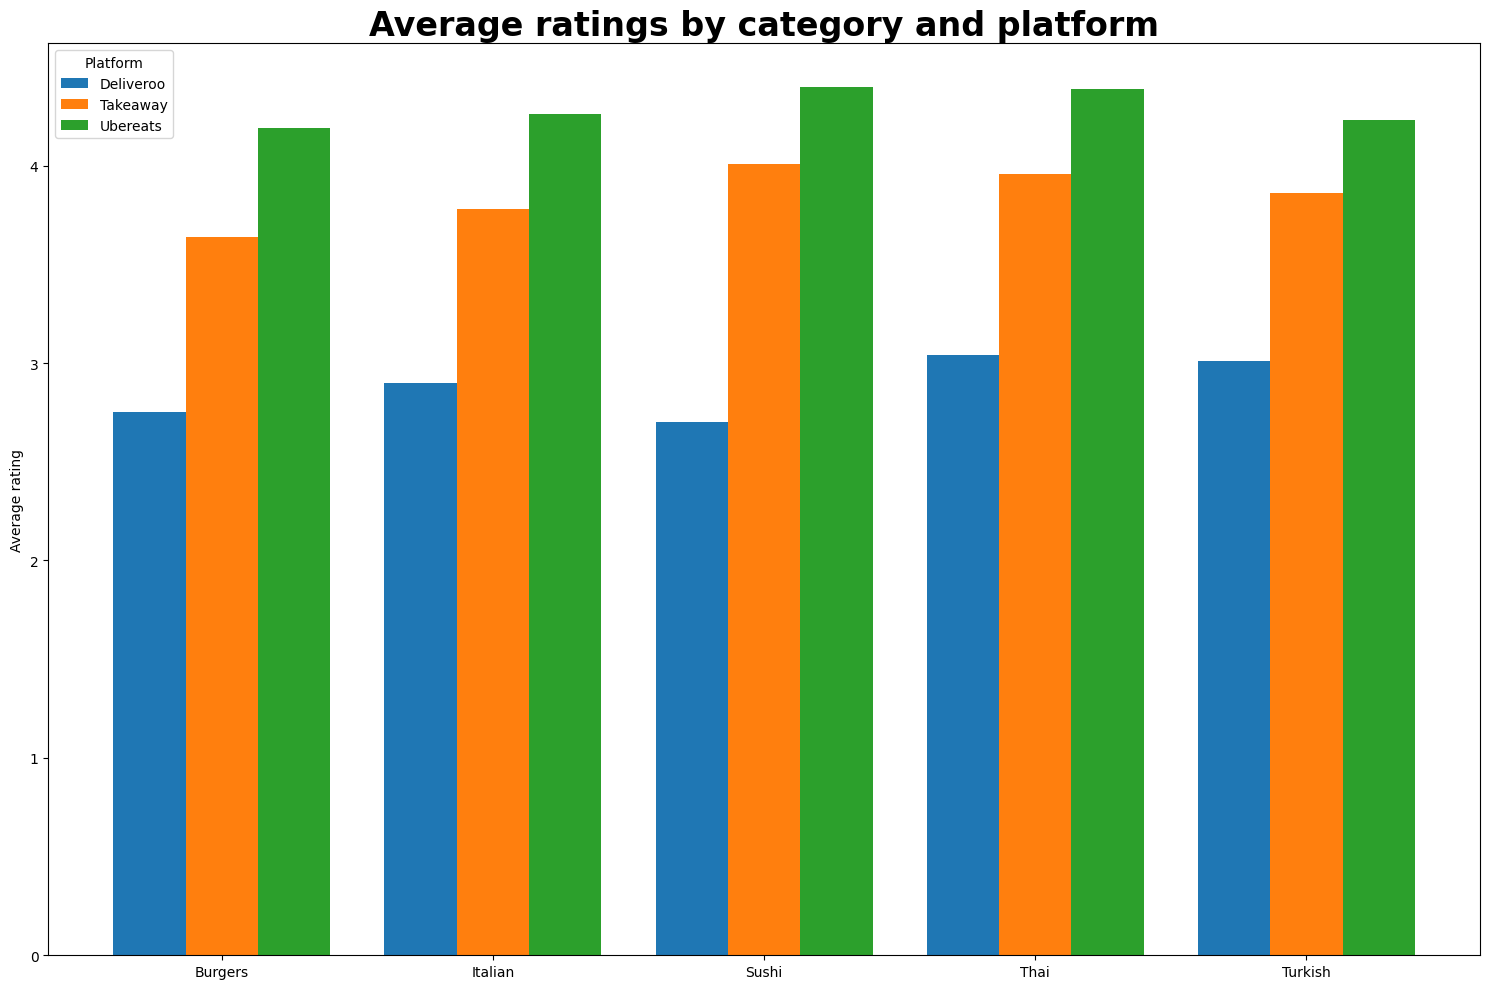

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Pivot to wide format: rows=Category, columns=Platform, values=Average rating
pivot = df_result.pivot(index="Category", columns="Platform", values="Average rating").fillna(0)

categories = pivot.index.tolist()
platforms = pivot.columns.tolist()

x = np.arange(len(categories))
width = 0.8 / max(len(platforms), 1)

plt.figure(figsize=(15, 10))

for i, p in enumerate(platforms):
    plt.bar(x + i*width - (len(platforms)-1)*width/2, pivot[p].values, width, label=p)

plt.xticks(x, categories, rotation=0)
plt.ylabel("Average rating")
plt.title("Average ratings by category and platform", fontsize=24, fontweight="bold")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()
